<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/Reproduction_of_a_foundational_PINN_method_to_generate_solution_to_1D_Burgers'_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on method presented in:  
*Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations*  
https://www.sciencedirect.com/science/article/pii/S0021999118307125?casa_token=IF_2eTCwVfkAAAAA:-AYLqjAlpXcFYBHje4sO2kMjqH3k0pdFQ7Qdpw1MazWxIGPwacb3Cp0gCtFRbNDAVLSsjCWU0g

In [1]:
# import required libraries and tools
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
from torch import nn

In [2]:
# define spatial and temporal domain extent
xMin = -1
xMax = 1
tMin = 0
tMax = 1

In [3]:
# create dataset
# number of points initial condition and boundary points
Nu = 20

# proportion of Nu which are initial condition points
prop_ic = 0.8
# number of initial condition points
Nu_i = int(prop_ic * Nu)
# number of boundary condition points
Nu_bc = Nu - Nu_i

# number of collocation points across input domain interior
Nf = 2000

In [4]:
# uniformly randomly select some points along the x axis to generate initial condition training points
uniformRandomXArray = rng.uniform(low=xMin, high=xMax, size=Nu_i)

# create array of initial condition defined training points
# t = 0
# x = uniformly random from x domain
# u = -1*sin(pi*x)
Nu_iSet= np.array([
                   np.zeros(Nu_i),
                   uniformRandomXArray,
                   -1 * np.sin(np.pi * uniformRandomXArray)
                    ]).T

In [5]:
# uniformly randomly select some points along the time axis to generate boundary condition training points
uniformRandomTArray = rng.uniform(low=tMin, high=tMax, size=Nu_bc)

# create array of boundary condition defined training points
# t = uniformly random from time domain
# x = random choice of -1 or 1
# u = 0
Nu_bcSet = np.array([
                        uniformRandomTArray,
                        rng.choice(np.array([-1,1]), size=Nu_bc, replace=True),
                        np.zeros(Nu_bc)
                        ]).T

In [6]:
# define empty array to hold initial and boundary conditions training points
NuTrainingSet = np.zeros((Nu, 3))
# add initial condition points
NuTrainingSet[:Nu_i,:] = Nu_iSet.copy()
# add boundary condition points
NuTrainingSet[Nu_i:,:] = Nu_bcSet.copy()

In [7]:
# shuffle initial and boundary condition training points
rng.shuffle(NuTrainingSet)
# convert numpy array to pytorch tensor
NuSetTensor = torch.from_numpy(NuTrainingSet.astype(np.float32))
# split into input and outputs for training
# set input tensor to store calculated gradients
NuX = NuSetTensor[:,:2].requires_grad_()
Nuy = NuSetTensor[:,2]

In [8]:
# create collocation training points selected uniformly randomly across input domain
NfSet = np.array([
               rng.uniform(tMin, tMax, Nf),
               rng.uniform(xMin, xMax, Nf),
               ]).T

# convert numpy array to pytorch tensor and set to store calculated gradients
NfTensor = torch.from_numpy(NfSet.astype(np.float32)).requires_grad_()

In [9]:
# define neural network architecture

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()        
        self.linear_stack = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),            
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),            
            nn.Linear(20, 20),         
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),            
            nn.Linear(20, 1),
        )            

    def forward(self, inputs):
        u = self.linear_stack(inputs)
        return u

In [22]:
# function to compute residual
# input: d x 2 dimensional tensor containing d (t, x) value pairs from input domain
# output: d x 1 dimensional tensor containing computed residual for 1D Burgers' equation
def residual(pointsArray_tx, viscosity=(0.01/np.pi)):
    # compute neural network solution approximations
    u = model(pointsArray_tx)
    # compute first derivatives of solution with respect to inputs (t, x)
    firstDerivatives = torch.autograd.grad(u, pointsArray_tx, torch.ones_like(u), create_graph=True)[0]
    # compute second derivatives with respect to inputs (t, x), mixed derivatives not required
    secondDerivatives = torch.autograd.grad(firstDerivatives, pointsArray_tx, torch.ones_like(firstDerivatives))[0] #, retain_graph=True

    # check if input data is being passed in batches
    if len(list(pointsArray_tx.size())) > 1:
        # extract tensors of derivatives
        ut = firstDerivatives[:,0] 
        ux = firstDerivatives[:,1]
        uxx = secondDerivatives[:,1]
    # get tensors of derivatives for sequential training mode
    else:
        ut = firstDerivatives[0] 
        ux = firstDerivatives[1]
        uxx = secondDerivatives[1]
    # compute and return residual using 1D burgers' equation
    return ut.flatten() + u.flatten() * ux.flatten() - viscosity * uxx.flatten()

In [27]:
# function to create arrays for plotting results
# input: x and y dimensions of solution space to plot
# output: 
# X and Y, 2D numpy arrays and size y*x to plot a matplotlib mesh
# U, 2D numpy array containing PINN approximated solution for all points within mesh
# R, 2D numpy array containing computed residual for all points within mesh
def meshPlotData(xDim, yDim):
    
    # create np arrays based on input domain extent and dimensions of mesh for plotting
    x = np.arange(tMin, tMax, (tMax-tMin)/xDim)
    y = np.arange(xMin, xMax, (xMax-xMin)/yDim)
    # create meshgrid arrays
    X, Y = np.meshgrid(x, y)

    # create empty array to contain all meshgrid points
    flattenedCoords = np.zeros((xDim*yDim, 2))
    # add meshgrid points, X ~ t and Y ~ x
    flattenedCoords[:,0] = X.flatten()
    flattenedCoords[:,1] = Y.flatten()
    # convert numpy array to pytorch tensor
    flattenedCoords = torch.from_numpy(flattenedCoords.astype(np.float32))

    # use PINN to approximate solution for all points
    flattenedU = model(flattenedCoords)
    # reshape solution array into meshgrid shape and convert to numpy
    U = torch.reshape(flattenedU, (yDim, xDim)).detach().numpy()

    # set flattened points to retain gradients during computation
    flattenedCoords = flattenedCoords.requires_grad_()
    # compute residual at all points
    flattened_R = residual(flattenedCoords)
    # reshape residual array into meshgrid shape and convert to numpy
    R = torch.reshape(flattened_R, (yDim, xDim)).detach().numpy()

    return X, Y, U, R

### Training and results

Network parameters: 2601


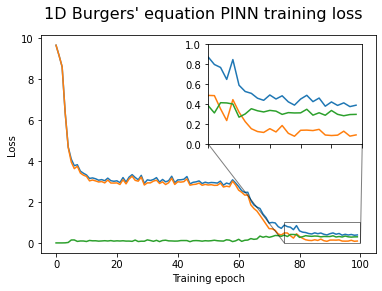

In [61]:
# create new network and print number of trainable parameters
model = NeuralNetwork()
print(f'Network parameters: {sum(p.numel() for p in model.parameters())}')

# initialise loss function and optimiser
MSEfunc = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters())

# initialise empty lists to store loss during at each stage of training
totalLoss = []
uLoss = []
fLoss = []

# number of training iterations
epochs = 100 #1000

# define batch size for initial and boundary condition points
uBatchSize = 1
# define batch size for collocation points
fBatchSize = 2000

# set model in training mode
model.train()
# iterate over training iterations
for epoch in range(epochs):

    # zero current epoch collocation points training loss
    fLossEpoch = 0
    # iterate over number of batches of collocation points
    for i in range(NfTensor.shape[0]//fBatchSize):
        # zero accumulated gradients
        optimiser.zero_grad()
        # compute collocation point error, based on residual
        MSEf = MSEfunc(residual(NfTensor[i*fBatchSize:(i+1)*fBatchSize]), torch.zeros(fBatchSize)) #  #torch.zeros(fBatchSize) #torch.tensor([0.])
        # increment current epoch collocation points training loss
        fLossEpoch += MSEf.item()
        # backpropagate loss
        MSEf.backward()
        # update model weights
        optimiser.step()
    # store current epoch collocation points training loss
    fLoss.append(fLossEpoch)

    # zero current epoch boundary and initial condition points training loss
    uLossEpoch = 0
    # shuffle boundary and initial condition points
    rng.shuffle(NuTrainingSet)
    # convert to pytorch tensor
    NuSetTensor = torch.from_numpy(NuTrainingSet.astype(np.float32))
    # split into input and correct outputs
    # set inputs to store computed gradients
    NuX = NuSetTensor[:,:2].requires_grad_()
    Nuy = NuSetTensor[:,2]
    # iterate over number of batches of boundary and initial condition points
    for i in range(NuX.shape[0]//uBatchSize):
        # zero accumulated gradients
        optimiser.zero_grad()
        # compute boundary and initial points training loss
        MSEu = MSEfunc(model(NuX[i*uBatchSize:(i+1)*uBatchSize]), torch.reshape(Nuy[i*uBatchSize:(i+1)*uBatchSize], (uBatchSize,1)))
        # increment current epoch boundary and initial points training loss
        uLossEpoch += MSEu.item()
        # backpropagate loss
        MSEu.backward()
        # update model weights
        optimiser.step()
    # store current epoch boundary and initial points training loss
    uLoss.append(uLossEpoch)   

    # store total epoch loss
    totalLoss.append(fLoss[-1] + uLoss[-1])

    # end of training epoch

# plot training loss curve
fig, ax = plt.subplots(figsize=(6,4))

# plot losses
ax.plot(totalLoss)
ax.plot(uLoss)
ax.plot(fLoss)
# label axes
ax.set_xlabel('Training epoch')
ax.set_ylabel('Loss')
# add an insert ax in top right corner
axins = ax.inset_axes([0.5, 0.5, 0.46, 0.46])
# plot losses on insert ax
axins.plot(totalLoss)
axins.plot(uLoss)
axins.plot(fLoss)
# set limits of insert ax
axins.set_xlim(3*epochs//4, epochs)
axins.set_ylim(0, 1)
# remove axes labels
axins.set_xticklabels([])
# axins.set_yticklabels([])
# add insert locator lines
ax.indicate_inset_zoom(axins, edgecolor="black")
# figure title
fig.suptitle("1D Burgers' equation PINN training loss", fontsize=16)

# fig.savefig("1D Burgers' - PINN training loss", bbox_inches='tight')
plt.show()

# set model in evaluation mode
model.eval()
# compute meshgrid, solution and residual for plotting
X, Y, U, R = meshPlotData(100, 100) 

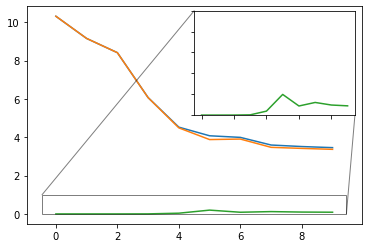

In [54]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(totalLoss)
ax.plot(uLoss)
ax.plot(fLoss)

axins = ax.inset_axes([0.5, 0.5, 0.48, 0.48])

axins.plot(totalLoss)
axins.plot(uLoss)
axins.plot(fLoss)

axins.set_ylim(0, 1)

axins.set_xticklabels([])
axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

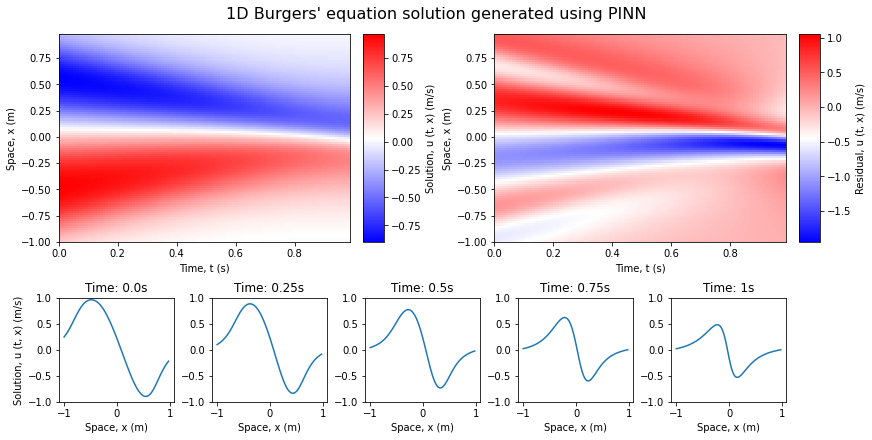

In [38]:
# create figure using gridspec to structure subplots
fig = plt.figure(
    figsize=(12, 6),
    constrained_layout=True
    )
gs = GridSpec(3, 20, figure=fig)

# add solution plot
solutionAx = fig.add_subplot(gs[:2,:10])
solutionPlot = solutionAx.pcolormesh(X, Y, U, cmap='bwr')
solutionAx.set_xlabel('Time, t (s)')
solutionAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(solutionPlot, use_gridspec=True)
cbar.set_label('Solution, u (t, x) (m/s)')

# add residual plot
residualAx = fig.add_subplot(gs[:2,10:])
residualPlot = residualAx.pcolormesh(X, Y, R, cmap='bwr')
residualAx.set_xlabel('Time, t (s)')
residualAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(residualPlot, use_gridspec=True)
cbar.set_label('Residual, u (t, x) (m/s)')

# iteratively create solution snapshot subplots
for i in range(5):
    tPlot = fig.add_subplot(gs[2, i*4:(i+1)*4])    
    if i < 4:
        tPlot.plot(Y[:, i*(Y.shape[1]//4)], U[:, i*(Y.shape[1]//4)])
        tPlot.set_title('Time: ' + str(i*X[0, X[0].shape[0]//4]) + 's')
    else:
        tPlot.plot(Y[:, -1], U[:, -1])
        tPlot.set_title('Time: ' + str(tMax) + 's')
    
    tPlot.set_ylim([-1, 1])
    tPlot.set_xlabel('Space, x (m)')
    if i == 0:
        tPlot.set_ylabel('Solution, u (t, x) (m/s)')

# figure title
fig.suptitle("1D Burgers' equation solution generated using PINN", fontsize=16)

# fig.savefig("1D Burgers' - PINN", bbox_inches='tight')
plt.show()